````code on sql

Select DATE(FROM_UNIXTIME(confirm_time/1000)) as Date, uid, pid, 
CASE type
	WHEN 202100 THEN 'NEW_INVESTMENT'
	WHEN 301100 THEN 'REBALANCE_DRIFT'
	WHEN 301300 THEN 'MORE_INVESTMENT'
	ELSE 'SELL_OUT'
END AS Advice,
amount
from v2_account_db.advice
where status = 900000
and DATE(FROM_UNIXTIME(confirm_time/1000)) >= '2021-01-01'

https://archery.aqumon.com/sqlquery/

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import os
import datetime as dt
import matplotlib.pyplot as plt

%matplotlib inline

input_path = "/Users/ansonleung/Downloads"

all_files = glob.glob(os.path.join(input_path, 'export_result*'))
file_count = 0
for file in all_files:
    df = pd.read_excel(file, parse_dates=['Date'])
    file_count +=1
    
print('Possessed File: '+ str(file_count))

df = df[df['Advice'] != 'REBALANCE_DRIFT']
df = df[df['pid'] != 21]


df['pid'] = df['pid'].apply(str)
product_list={'HKD': ['12', '32', '2306', '2310', '2170', '2130', '2160'],
 'USD': ['13','33','55','3110','3120','3210','3220','3310','3320','3180','3130','3140','3000'],
 'CNY': ['4410', '4510']}
usd_rate = 7.8
cny_rate = 1.2
hkd_rate = 1

#df.amount = df.amount.apply(lambda x: float(x.strip("'")))

df1 = df[df.pid.isin(product_list['USD'])].amount * usd_rate
df2 = df[df.pid.isin(product_list['CNY'])].amount * cny_rate
df3 = df[df.pid.isin(product_list['HKD'])].amount * hkd_rate

df['amount_in_hkd']=pd.concat([df1,df2,df3])
product_legend2 = {
'12':'SG', '32':'SG',
'13':'SGM','33':'SGM',
'55':'SGX',
'3110':'Profit M.', '3120':'Profit M.',
'3210':'Bus. Win.','3220':'Bus. Win.',
'3310':'Glob T.','3320':'Glob T.',
'3180':'ESG',
'3130':'US Lead',
'3140':'Health',
'3000':'Cash',
'4410':'Blue C.', 
'4510':'Hidden G.',
'2306':'Chin Tech', '2310':'Chin Tech', 
'2170':'High Div', 
'2130':'HK Lead', 
'2160':'Prop M.'}
df = df.replace({'pid':product_legend2})
df = df.drop('amount',1)
df3 = df
df = df.drop('uid',1)

output_file = '/Users/ansonleung/Desktop/allocation_hist_weekly.xlsx'
writer = pd.ExcelWriter(output_file)
df1 = df

df1['WeekDate'] = df.apply(lambda row: row['Date'] - dt.timedelta(days=row['Date'].weekday()), axis=1)
df1['WeekDate']= df1['WeekDate'].dt.date
df1 = df1.groupby(['WeekDate','pid','Advice'],as_index=False).agg(amount_in_hkd = ('amount_in_hkd', 'sum'), count=('Advice', 'count'))
df1 =pd.DataFrame(df1)

df1_sell = df1[(df1['Advice']=='SELL_OUT')].drop(['Advice','count'], axis=1)
df1_sell = pd.pivot_table(df1_sell,index=['WeekDate'] ,columns=["pid"])
df1_sell.columns = df1_sell.columns.droplevel(0)
df1_sell.columns.name = None

df1_sell.loc['Total'] =df1_sell.sum(axis = 0)
df1_sell['Week Total'] =df1_sell.sum(axis = 1)
df1_sell = df1_sell*-1
df1_sell = df1_sell[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Week Total']]

df1_more = df1[(df1['Advice']=='MORE_INVESTMENT')].drop(['Advice','count'], axis=1)
df1_more = pd.pivot_table(df1_more,index=['WeekDate'] ,columns=["pid"])
df1_more.columns = df1_more.columns.droplevel(0)
df1_more.columns.name = None

df1_more.loc['Total'] =df1_more.sum(axis = 0)
df1_more['Week Total'] =df1_more.sum(axis = 1)
df1_more = df1_more[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Week Total']]

df1_new = df1[(df1['Advice']=='NEW_INVESTMENT')].drop(['Advice','count'], axis=1)
df1_new = pd.pivot_table(df1_new,index=['WeekDate'] ,columns=["pid"])
df1_new.columns = df1_new.columns.droplevel(0)
df1_new.columns.name = None

df1_new.loc['Total'] =df1_new.sum(axis = 0)
df1_new['Week Total'] =df1_new .sum(axis = 1)
df1_new  = df1_new[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Week Total']]


df1_total_t = df1[(df1['Advice']!='SELL_OUT')].groupby(['WeekDate','pid'],as_index=False).agg(amount_in_hkd = ('amount_in_hkd', 'sum'), count=('count', 'sum'))
df1_total = df1_total_t.drop(['count'], axis=1)
df1_total = pd.pivot_table(df1_total,index=['WeekDate'] ,columns=["pid"])
df1_total.columns = df1_total.columns.droplevel(0)
df1_total.columns.name = None

df1_total.loc['Total'] =df1_total.sum(axis = 0)
df1_total['Week Total'] =df1_total.sum(axis = 1)
df1_total  = df1_total[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Week Total']]

df1_new_count = df1[(df1['Advice']=='NEW_INVESTMENT')].drop(['Advice','amount_in_hkd'], axis=1)
df1_new_count = pd.pivot_table(df1_new_count,index=['WeekDate'] ,columns=["pid"])
df1_new_count.columns = df1_new_count.columns.droplevel(0)
df1_new_count.columns.name = None

df1_new_count.loc['Total'] =df1_new_count.sum(axis = 0)
df1_new_count['Week Total'] =df1_new_count.sum(axis = 1)
df1_new_count  = df1_new_count[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Week Total']]


df1_more_count = df1[(df1['Advice']=='MORE_INVESTMENT')].drop(['Advice','amount_in_hkd'], axis=1)
df1_more_count = pd.pivot_table(df1_more_count,index=['WeekDate'] ,columns=["pid"])
df1_more_count.columns = df1_more_count.columns.droplevel(0)
df1_more_count.columns.name = None

df1_more_count.loc['Total'] =df1_more_count.sum(axis = 0)
df1_more_count['Week Total'] =df1_more_count.sum(axis = 1)
df1_more_count  = df1_more_count[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Week Total']]


df1_sell_count = df1[(df1['Advice']=='SELL_OUT')].drop(['Advice','amount_in_hkd'], axis=1)
df1_sell_count = pd.pivot_table(df1_sell_count,index=['WeekDate'] ,columns=["pid"])
df1_sell_count.columns = df1_sell_count.columns.droplevel(0)
df1_sell_count.columns.name = None

df1_sell_count.loc['Total'] =df1_sell_count.sum(axis = 0)
df1_sell_count['Week Total'] =df1_sell_count.sum(axis = 1)
df1_sell_count  = df1_sell_count[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Week Total']]

df1_total_count = df1_total_t.drop(['amount_in_hkd'], axis=1)
df1_total_count = pd.pivot_table(df1_total_count,index=['WeekDate'] ,columns=["pid"])
df1_total_count.columns = df1_total_count.columns.droplevel(0)
df1_total_count.columns.name = None

df1_total_count.loc['Total'] =df1_total_count.sum(axis = 0)
df1_total_count['Week Total'] =df1_total_count.sum(axis = 1)
df1_total_count = df1_sell_count[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Week Total']]


df1_total.to_excel(writer, sheet_name='TOTAL_ALLOCATION')
df1_total_count.to_excel(writer, sheet_name='TOTAL_ALLOCATION_COUNT')

df1_sell.to_excel(writer, sheet_name='SELL_OUT')
df1_sell_count.to_excel(writer, sheet_name='SELL_OUT_COUNT')

df1_new.to_excel(writer, sheet_name='NEW_INVESTMENT')
df1_new_count.to_excel(writer, sheet_name='NEW_INVESTMENT_COUNT')


df1_more.to_excel(writer, sheet_name='MORE_INVESTMENT')
df1_more_count.to_excel(writer, sheet_name='MORE_INVESTMENT_COUNT')


df3.to_excel(writer, sheet_name='RAW_DATA')
#df.set_index('Date').to_excel(writer, sheet_name='RAW_DATA')


writer.save()

Possessed File: 1


In [10]:

output_file = '/Users/ansonleung/Desktop/allocation_hist_day.xlsx'
writer1 = pd.ExcelWriter(output_file)

df2 = df.groupby(['Date','pid','Advice'],as_index=False).agg(amount_in_hkd = ('amount_in_hkd', 'sum'), count=('Advice', 'count'))
df2 =pd.DataFrame(df2)
df2['Date']= df2['Date'].dt.date


df2_sell = df2[(df2['Advice']=='SELL_OUT')].drop(['Advice','count'], axis=1)
df2_sell = pd.pivot_table(df2_sell,index=['Date'] ,columns=["pid"])
df2_sell.columns = df2_sell.columns.droplevel(0)
df2_sell.columns.name = None

df2_sell.loc['Total'] =df2_sell.sum(axis = 0)
df2_sell['Day Total'] =df2_sell.sum(axis = 1)
df2_sell = df2_sell*-1
df2_sell = df2_sell[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Day Total']]

df2_more = df2[(df2['Advice']=='MORE_INVESTMENT')].drop(['Advice','count'], axis=1)
df2_more = pd.pivot_table(df2_more,index=['Date'] ,columns=["pid"])
df2_more.columns = df2_more.columns.droplevel(0)
df2_more.columns.name = None

df2_more.loc['Total'] =df2_more.sum(axis = 0)
df2_more['Day Total'] =df2_more.sum(axis = 1)
df2_more = df2_more[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Day Total']]

df2_new = df2[(df2['Advice']=='NEW_INVESTMENT')].drop(['Advice','count'], axis=1)
df2_new = pd.pivot_table(df2_new,index=['Date'] ,columns=["pid"])
df2_new.columns = df2_new.columns.droplevel(0)
df2_new.columns.name = None

df2_new.loc['Total'] =df2_new.sum(axis = 0)
df2_new['Day Total'] =df2_new.sum(axis = 1)
df2_new = df2_new[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Day Total']]



df2_total_t = df2[(df2['Advice']!='SELL_OUT')].groupby(['Date','pid'],as_index=False).agg(amount_in_hkd = ('amount_in_hkd', 'sum'), count=('count', 'sum'))
df2_total = df2_total_t.drop(['count'], axis=1)
df2_total = pd.pivot_table(df2_total,index=['Date'] ,columns=["pid"])
df2_total.columns = df2_total.columns.droplevel(0)
df2_total.columns.name = None

df2_total.loc['Total'] =df2_total.sum(axis = 0)
df2_total['Day Total'] =df2_total.sum(axis = 1)
df2_total = df2_total[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Day Total']]


df2_sell_count = df2[(df2['Advice']=='SELL_OUT')].drop(['Advice','amount_in_hkd'], axis=1)
df2_sell_count = pd.pivot_table(df2_sell_count,index=['Date'] ,columns=["pid"])
df2_sell_count.columns = df2_sell_count.columns.droplevel(0)
df2_sell_count.columns.name = None

df2_sell_count.loc['Total'] =df2_sell_count.sum(axis = 0)
df2_sell_count['Day Total'] =df2_sell_count.sum(axis = 1)
df2_sell_count = df2_sell_count[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Day Total']]


df2_more_count = df2[(df2['Advice']=='SELL_OUT')].drop(['Advice','amount_in_hkd'], axis=1)
df2_more_count = pd.pivot_table(df2_more_count,index=['Date'] ,columns=["pid"])
df2_more_count.columns = df2_more_count.columns.droplevel(0)
df2_more_count.columns.name = None

df2_more_count.loc['Total'] =df2_more_count.sum(axis = 0)
df2_more_count['Day Total'] =df2_more_count.sum(axis = 1)
df2_more_count = df2_more_count[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Day Total']]

df2_new_count = df2[(df2['Advice']=='SELL_OUT')].drop(['Advice','amount_in_hkd'], axis=1)
df2_new_count = pd.pivot_table(df2_new_count,index=['Date'] ,columns=["pid"])
df2_new_count.columns = df2_new_count.columns.droplevel(0)
df2_new_count.columns.name = None

df2_new_count.loc['Total'] =df2_new_count.sum(axis = 0)
df2_new_count['Day Total'] =df2_new_count.sum(axis = 1)
df2_new_count = df2_new_count[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Day Total']]

df2_total_count = df2_total_t.drop(['amount_in_hkd'], axis=1)
df2_total_count = pd.pivot_table(df2_total_count,index=['Date'] ,columns=["pid"])
df2_total_count.columns = df2_total_count.columns.droplevel(0)
df2_total_count.columns.name = None

df2_total_count.loc['Total'] =df2_total_count.sum(axis = 0)
df2_total_count['Day Total'] =df2_total_count.sum(axis = 1)
df2_total_count = df2_total_count[['SG','SGM','SGX',
'Glob T.', 'Profit M.', 'Bus. Win.', 'US Lead','Health', 'ESG',
'Chin Tech', 'High Div','Prop M.','HK Lead',
'Blue C.',  'Hidden G.',      
'Cash','Day Total']]


df2_total.to_excel(writer1, sheet_name='TOTAL_ALLOCATION')
df2_total_count.to_excel(writer1, sheet_name='TOTAL_ALLOCATION_COUNT')

df2_sell.to_excel(writer1, sheet_name='SELL_OUT')
df2_sell_count.to_excel(writer1, sheet_name='SELL_OUT_COUNT')


df2_new.to_excel(writer1, sheet_name='NEW_INVESTMENT')
df2_new_count.to_excel(writer1, sheet_name='NEW_INVESTMENT_COUNT')

df2_more.to_excel(writer1, sheet_name='MORE_INVESTMENT')
df2_more_count.to_excel(writer1, sheet_name='MORE_INVESTMENT_COUNT')

#df2.set_index('Date').to_excel(writer1, sheet_name='RAW_DATA')

df3.to_excel(writer1, sheet_name='RAW_DATA')

writer1.save()

In [11]:
# df = df[(df['Date'] <= '2021-06-31')]
df = df[(df['Date'] >= '2021-08-01') & (df['Date'] <= '2021-08-29')]

df1 = df.groupby(['pid','Advice'],as_index=False).agg(amount_in_hkd = ('amount_in_hkd', 'sum'), count=('Advice', 'count'))
df1 =pd.DataFrame(df1)
df1

,pid,Advice,amount_in_hkd,count
0,2180,MORE_INVESTMENT,0.000000e+00,2
1,2180,NEW_INVESTMENT,0.000000e+00,10
2,2180,SELL_OUT,0.000000e+00,1
3,Blue C.,MORE_INVESTMENT,4.200043e+04,1
4,Blue C.,SELL_OUT,-4.763702e+05,19
5,Bus. Win.,MORE_INVESTMENT,1.788084e+05,13
6,Bus. Win.,NEW_INVESTMENT,1.438098e+05,12
7,Bus. Win.,SELL_OUT,-2.155008e+05,11
8,Cash,MORE_INVESTMENT,2.085084e+05,9
9,Cash,NEW_INVESTMENT,1.877508e+05,32


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


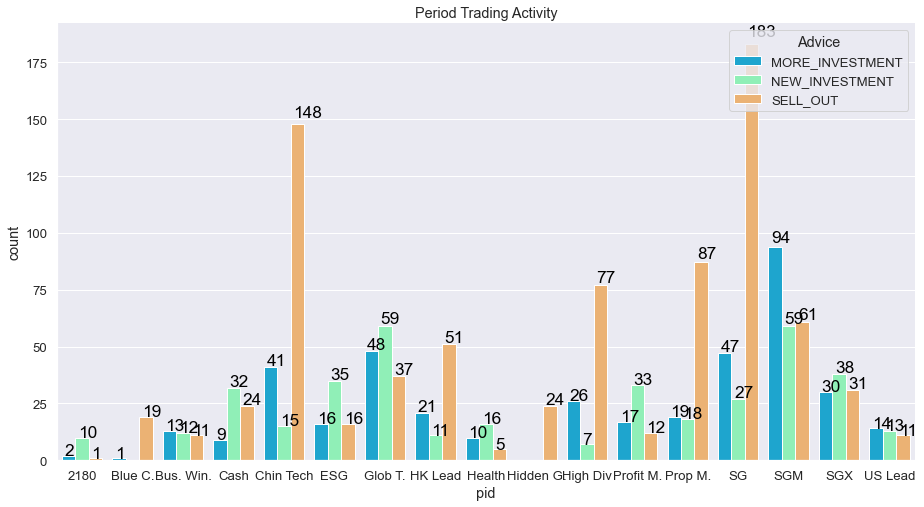

In [12]:
sns.set(font_scale=1.2)

g = sns.catplot(
    data=df1, kind="bar",
    x="pid", y="count", hue="Advice",
    palette="rainbow",height=10,legend_out=False
)

g.fig.set_size_inches(15,8)

g.fig.subplots_adjust(top=0.81,right=0.86) 

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x()+0.05, 
            p.get_height()*1.02, 
           '{:.0f}'.format(p.get_height()),   #Used to format it K representation
            color='black', 
            rotation='horizontal', 
            size='large')
ax.set_title("Period Trading Activity")
g.savefig('/Users/ansonleung/Desktop/trade_count_week.png')
    

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


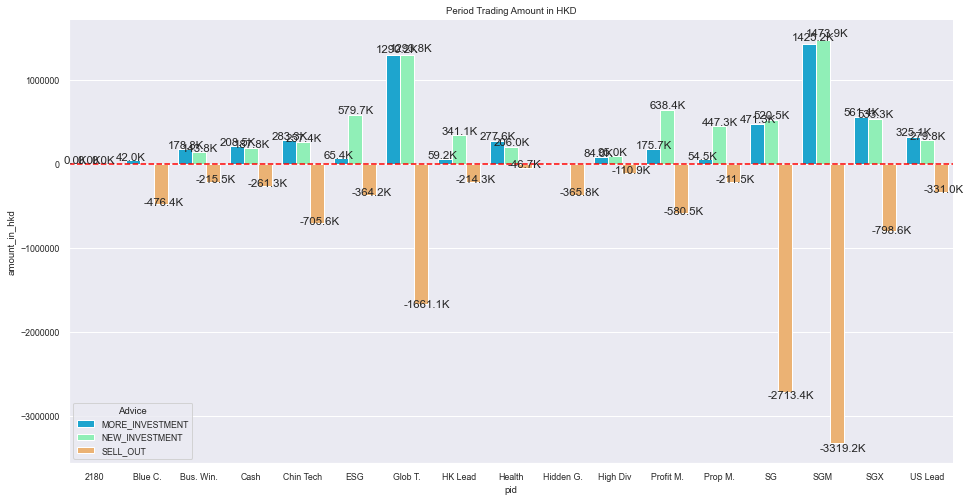

In [13]:
sns.set(font_scale=0.8)
g = sns.catplot(
    data=df1, kind="bar",
    x="pid", y="amount_in_hkd", hue="Advice",
    palette="rainbow",height=10,legend_out=False
)

g.fig.set_size_inches(15,8)

g.fig.subplots_adjust(top=0.81,right=0.86) 
plt.ticklabel_format(style='plain', axis='y')

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x()-0.2, p.get_height()*1.03,
            '{0:.1f}K'.format(p.get_height()/1000), #Used to format it K representation
             
            rotation='horizontal', 
            size='large')
ax.axhline(20, ls='--', c='red')
ax.set_title("Period Trading Amount in HKD")

g.savefig('/Users/ansonleung/Desktop/trade_amount_week.png')

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


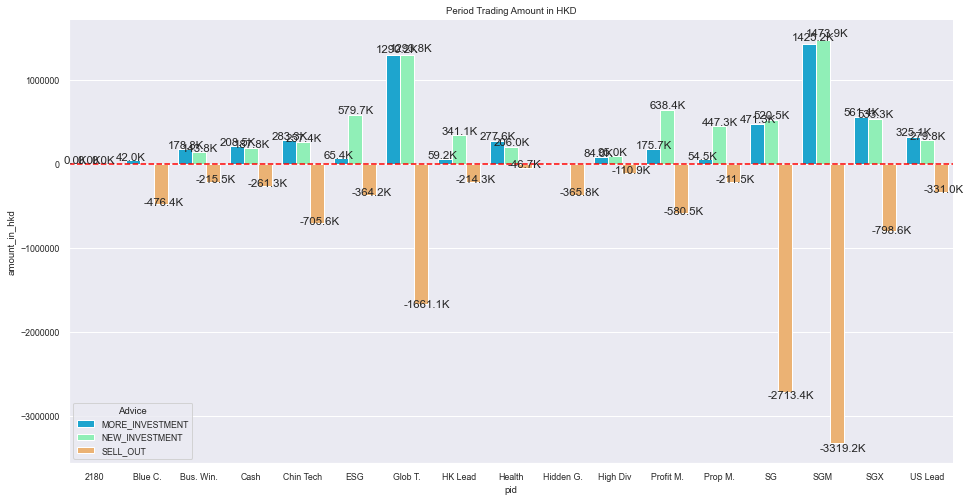

In [14]:
sns.set(font_scale=0.8)
g = sns.catplot(
    data=df1, kind="bar",
    x="pid", y="amount_in_hkd", hue="Advice",
    palette="rainbow",height=10,legend_out=False
)

g.fig.set_size_inches(15,8)

g.fig.subplots_adjust(top=0.81,right=0.86) 
plt.ticklabel_format(style='plain', axis='y')

ax = g.facet_axis(0,0)
for p in ax.patches:
    ax.text(p.get_x()-0.2, p.get_height()*1.03,
            '{0:.1f}K'.format(p.get_height()/1000), #Used to format it K representation
             
            rotation='horizontal', 
            size='large')
ax.axhline(20, ls='--', c='red')
ax.set_title("Period Trading Amount in HKD")

g.savefig('/Users/ansonleung/Desktop/trade_amount_week.png')

In [1]:
#delete data
import pandas as pd
import csv
import glob
import os
import sys
import numpy as np
index = 0
input_path = "/Users/ansonleung/Downloads"
all_files = glob.glob(os.path.join(input_path, 'export_result*'))
for i in all_files: 
    if os.path.exists(i):
        os.remove(i)
        index+=1
print(f'{index} files deleted')

2 files deleted
